In [1]:
import pandas as pd
import numpy as np
import os
import CRPS.CRPS as pscore
import copy
from joblib import dump, load
from scipy.stats import nbinom, poisson
from time import sleep
from tqdm import tqdm
import warnings

# create the feature- and actuals-data list
# set the feature and actuals year lists
feature_years = ['2017','2018','2019','2020']
actual_years = ['2018','2019','2020','2021']

actuals_df_list = []
features_df_list = []

# path to the current directory
current_dir = os.getcwd()

for i in range(len(feature_years)):
    # relative paths to the parquet files
    relative_path_features = os.path.join('..', 'data', 'cm_features_to_oct' + feature_years[i] + '.parquet')
    relative_path_actuals = os.path.join('..', 'data', 'cm_actuals_' + actual_years[i] + '.parquet')

    path_features = os.path.join(current_dir, relative_path_features)
    path_actuals = os.path.join(current_dir, relative_path_actuals)

    # append datasets to the lists
    actuals_df_list.append({'year':actual_years[i], 'data':pd.read_parquet(path_actuals, engine='pyarrow')})
    features_df_list.append({'year':feature_years[i], 'data':pd.read_parquet(path_features, engine='pyarrow')})

# concat the feature datasets, so that every data contains the observations starting with january 1990
for i in range(1,len(features_df_list)):
    features_df_list[i]['data'] = pd.concat([features_df_list[i-1]['data'], features_df_list[i]['data']])

country_list = sorted(features_df_list[3]['data'].index.get_level_values('country_id').unique().tolist())

# country group list of all four datasets
country_feature_group_list = []
country_actual_group_list = []
# fill list 
for i in range(len(features_df_list)):
    country_feature_group_list.append(features_df_list[i]['data'].groupby('country_id'))
    country_actual_group_list.append(actuals_df_list[i]['data'].groupby('country_id'))

In [2]:
# check for nan's
is_na_series = features_df_list[0]['data'].isna().sum()

for i in range(len(is_na_series)):
    if is_na_series[i] > 0 :
        print(str(is_na_series.index[i]) + ': ' + str(is_na_series[i]))

## First Neural Net 
The first NN is only to predict the month s=3 due to simplicity. It only has one input node, i.e. the last w observed fatalities ('ged_sb'). It has one hidden layer and two output nodes. One for the parameter n of the negative binomial distribution and one for the parameter p. 

In [4]:
features = country_feature_group_list[3].get_group(246)
features

,,gleditsch_ward,ged_sb,ged_ns,ged_os,acled_sb,acled_sb_count,acled_os,ged_sb_tsum_24,wdi_sp_pop_totl,ged_sb_tlag_1,...,ind_efficiency_t48,irr_agr_efficiency_t48,services_efficiency_t48,general_efficiency_t48,water_stress_t48,renewable_internal_pcap_t48,renewable_pcap_t48,splag_1_decay_ged_sb_5,splag_1_decay_ged_os_5,splag_1_decay_ged_ns_5
month_id,country_id,,,,,,,,,,,,,,,,,,,,,
379,246,626,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10243050.0,0.0,...,10.067134,0.012448,7.508171,5.649194,4.226076,2570.783305,4894.375907,0.000000,0.000000,0.000000
380,246,626,60.0,640.0,0.0,380.0,10.0,1836.0,60.0,10243050.0,0.0,...,10.067134,0.012448,7.508171,5.649194,4.226076,2570.783305,4894.375907,3.961023,4.292905,4.457506
381,246,626,6.0,46.0,0.0,0.0,0.0,1.0,66.0,10243050.0,60.0,...,10.067134,0.012448,7.508171,5.649194,4.226076,2570.783305,4894.375907,3.904386,4.255288,4.386735
382,246,626,84.0,6.0,0.0,60.0,2.0,35.0,150.0,10243050.0,6.0,...,10.067134,0.012448,7.508171,5.649194,4.226076,2570.783305,4894.375907,3.877829,4.134149,4.344849
383,246,626,26.0,0.0,0.0,18.0,2.0,7.0,176.0,10243050.0,84.0,...,10.067134,0.012448,7.508171,5.649194,4.226076,2570.783305,4894.375907,3.824371,4.255625,4.277286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
486,246,626,3.0,74.0,6.0,116.0,13.0,79.0,224.0,10447666.0,13.0,...,23.998790,0.041360,35.247547,18.559925,4.226076,2400.180641,4569.574682,4.678154,5.020182,4.985520
487,246,626,9.0,127.0,5.0,10.0,9.0,165.0,222.0,10447666.0,3.0,...,23.998790,0.041360,35.247547,18.559925,4.226076,2400.180641,4569.574682,4.925024,4.934203,5.179843
488,246,626,24.0,0.0,4.0,176.0,11.0,31.0,236.0,10447666.0,9.0,...,23.998790,0.041360,35.247547,18.559925,4.226076,2400.180641,4569.574682,4.869412,5.015899,5.117787


#### basic tensor operations

In [19]:
import torch
# in PyTorch there are no lists/arrays etc: everything is a tensor
y = torch.empty(2,2) # 2 dimensional tensor (matrix)
x = torch.rand(2,2, dtype = torch.float)

y.add_(x) # _ functions do an inplace operation -> modifies the variable that it is applied on
print(y[:,0]) # slicing same as in numpy/pandas
y[1,1].item() # returns the actual item itself
y.size()

x = torch.tensor(features['ged_sb'].tail(12).values)
x

tensor([0.4017, 0.0521])


tensor([ 0.,  0.,  2.,  0.,  0.,  1., 13.,  3.,  9., 24.,  1.,  0.],
       dtype=torch.float64)

#### gradient calculation with autograd

In [ ]:
x = torch.randn(3, requires_grad=True) # req grad has to be specified if we want to calc the gradient
# if this is made, pytorch creates an operational graph (see picture below) e.g.
x = z + 2


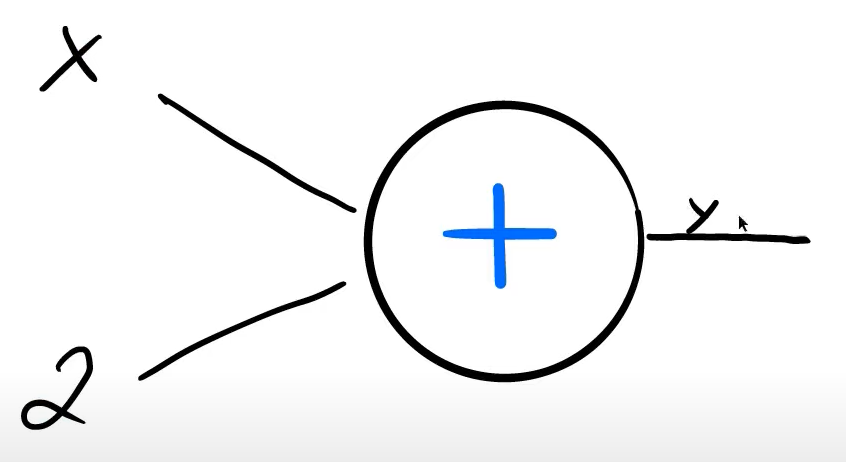

#### backpropagation

#### gradient descent with autograd

#### training pipeline

#### dataset and dataloader classes

#### dataset transforms

#### activation functions: softmax and cross entropy loss